In [20]:
import math
import numpy as np
from tqdm import tqdm

In [21]:
#warning settings
np.seterr(all="ignore") #ignore np warnings, the output will be nan or inf and will be handled correctly in the code. (using np.errstate slows down the code)

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [22]:
# Configuration
TRAIN_TEST_RATIO=0.8
PROBLEM_NUMBER=1

### Data Loading and Data Preprocessing

In [23]:
# Load problem data with context manager protocol
with np.load(f'../data/problem_{PROBLEM_NUMBER}.npz') as problem:
    x_1 = problem['x']
    y_1 = problem['y']

# Shuffle the data
permutation = np.random.permutation(len(y_1))
x_1 = x_1[:, permutation]
y_1 = y_1[permutation]

# Determine train test split sizes
problem_len=len(y_1)
train_size=int(TRAIN_TEST_RATIO*problem_len)

# Split data
x_train = x_1[:, :train_size]
y_train = y_1[:train_size]

x_test = x_1[:, train_size:]
y_test = y_1[train_size:]


# Print dataset information
print(f"Problem number: {PROBLEM_NUMBER}, variables: {x_1.shape[0]}, train size: {train_size}, test size: {problem_len-train_size}")

print(f"Training data: x shape {x_train.shape}, y shape {y_train.shape}")
print(f"Testing data: x shape {x_test.shape}, y shape {y_test.shape}")

Problem number: 1, variables: 1, train size: 350, test size: 150
Training data: x shape (1, 350), y shape (350,)
Testing data: x shape (1, 150), y shape (150,)


### NumPy Unary and Binary Operations

In [24]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    np.arcsin,
    np.arccos,
    np.arctan,
    np.sinh,
    np.cosh,
    np.tanh,
    np.square,
    np.cbrt,
    np.reciprocal,
    np.ceil,
    np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    np.maximum,
    np.minimum,
    np.mod
]

### Symbolic Regression Class

In [25]:
from tree import Tree

class SymbolicRegression:
    """
    A class to implement symbolic regression using an evolutionary algorithm 
    with an island model approach.

    Parameters:
        - population_per_island (int): Number of individuals (trees) on each island.
        - island_num (int): Number of islands (sub-populations).
        - max_generations (int): Maximum number of generations before stopping.
        - mutation_rate (float): Mutation probability occurring in a tree.
        - elitism_size (int): Number of top individuals directly inserted in the next generation.
        - grow_full_ratio (float): Ratio of trees initialized with grow method vs. full method.
        - max_mutations (int): Maximum number of mutations an individual can be subjected.
        - migration_rate (float): Probability of a migration event between islands.
        - collapse_rate (float): Probability of population collapse to introduce diversity.

    Attributes:
        - unary_ops (list): List of unary operations.
        - binary_ops (list): List of binary operations.
        - best_fitness_history (list): List that stores the best fitness for each generation.
        - population (list of np.array): List of sub-populations (islands).

    Returns:

    """
    def __init__(self, population_per_island, island_num, max_generations, mutation_rate, elitism_size, grow_full_ratio, max_mutations, migration_rate, collapse_rate):
        self.population_per_island = population_per_island
        self.island_num = island_num
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio
        self.max_mutations = max_mutations
        self.migration_rate = migration_rate
        self.collapse_rate=collapse_rate

        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.best_fitness_history = []
        self.population = [None] * island_num

        for j in range(island_num):
            self.population[j] = np.array([
                Tree("grow") if i < int(population_per_island * self.grow_full_ratio) else Tree("full") for i in range(population_per_island)
            ])
            Tree.create_tree_from_np_formula

    # Parents selection methods
    def select_parents_fitness_proportional(self, n_elems=2, epsilon=1e-10, island=0):
        """
        Selects parents using fitness proportional selection method.

        This method randomly selects `n_elems` individuals based on their fitness.
        Individuals with lower fitness have an higher probability to be selected.
        This approach helps maintain diversity, but may lead to premature convergence 
        if few individuals have significantly better fitness than others.

        Parameters:
            - n_elems (int): Number of individuals to select.
            - epsilon (float): Small value to avoid division by zero.
            - island (int): Island on which the selection should be done.
        
        Returns:
            - A tuple containing the `n_elems` selected parents.
        """
        fitnesses = [tree.fitness for tree in self.population[island]]
        inverted_fitnesses = [1 / (fitness + epsilon) for fitness in fitnesses]  # avoid division by zero
        probabilities = inverted_fitnesses / sum(inverted_fitnesses)
        parent1, parent2 = np.random.choice(self.population[island], size=n_elems, p=probabilities, replace=False)
        return parent1, parent2
    
    
    def select_parents_rank_based(self, n_elems=2, island=0, exponential=False):
        """
        Selects parents using rank based selection method.

        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        Parameters:
            - n_elems (int): Number of individuals to select.
            - island (int): Island on which the selection should be done.
            - exponential (bool): If True, the ranks are raised to the power of the exponential parameter.
        
        Returns:
            - A tuple containing the `n_elems` selected parents.
        """
        fitnesses = np.array([tree.fitness for tree in self.population[island]])
        ranks = np.argsort(fitnesses)
        if exponential:
            ranks = ranks**exponential
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population[island], n_elems, p=probabilities, replace=False)
    
    
    def select_parents_tournament(self, island=0):
        """
        Selects parents using tournament selection method.

        This method randomly selects a subset (tournament) of the population and selects the two 
        individuals with the best fitness from the subset as parents.

        Parameters:
            - island (int): Island on which the selection should be done.
        
        Returns:
            - A tuple containing the two selected parents.
        """
        tournament_size = 5
        tournament = list(np.random.choice(self.population[island], tournament_size, replace=True))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]
    
    # Choose the parents selection method
    def select_parents(self, island, method="rank"):
        """
        Select parents based on the specified method.

        Parameters:
            - island (int): Island on which the selection should be done.
            - method (str): The parent selection method to use.

        Returns:
            - A tuple containing the two selected parents.
        """
        if method == "rank":
            return self.select_parents_rank_based(island=island)
        elif method == "fitness_proportional":
            return self.select_parents_fitness_proportional(island=island)
        elif method == "tournament":
            return self.select_parents_tournament(island=island)
        else:
            return self.select_parents_rank_based(island=island)
            
            
    # Mutation methods
    def mutate(self, tree):
        if np.random.rand() < 0.5:
            tree.mutate_subtree()
        else:
            mutations = np.random.randint(1, self.max_mutations+1)
            tree.mutate_single_node(num_mutations=mutations)
        
       


    # Offsprings generation via mutation and crossover
    def offspring_generation(self,island):
        new_population = np.array([])

        # Elitism   
        elite_individuals = self.population[island][:self.elitism_size]
        new_population = elite_individuals

        # Main loop
        while len(new_population) < self.population_per_island//2: 
            parent1, parent2 = self.select_parents(island=island)
            # generate offsprings (one in mutation, two in crossover)
            offsprings = np.array([])

            if(np.random.rand() < self.mutation_rate):
                parent_clone = parent1.copy_tree()
                self.mutate(parent_clone)
              
                parent_clone.compute_fitness()
                #if the fitness is valid 
                if(parent_clone.fitness is not np.inf and parent_clone.fitness is not np.nan):
                    #to not re-add the same tree if the mutation was not possible (e.g. the tree is already a leaf and other edge cases)
                    if( parent_clone.fitness!=parent1.fitness):
                        offsprings = np.append(offsprings, [parent_clone])

            else:    
                offspring1, offspring2 = parent1.crossover(parent2)
                if(offspring1 is not None and offspring2 is not None):
               
                    offspring1.compute_fitness()
                    offspring2.compute_fitness()

                    offsprings = np.append(offsprings, [offspring1, offspring2])

            # Collapse branch
            for offsp in offsprings:
                if(np.random.rand() < self.collapse_rate):
                    #clone the tree and collapse the branch
                    tree_clone = offsp.copy_tree()
                
                    Tree.collapse_branch(tree_clone.root,force_collapse=True)
                    tree_clone.compute_fitness()
                    #if the fitness is not nan or inf after collapsing
                    if(tree_clone.fitness is not None or tree_clone.fitness is not np.inf and tree_clone.fitness is not np.nan):
                            offsp = tree_clone

            new_population = np.concatenate((new_population, offsprings))
                
        return new_population
    
    # Genetic Algorithm: Evolutionary Process
    def evolve(self, verbose=False, use_std_operators=False):
        best_tree_island = np.full(self.island_num, None, dtype=object)
        best_fitness_island = np.full(self.island_num, np.inf)
        global_best_fitness = np.inf
        global_best_tree = None
        take_over = np.full(self.island_num, False)
        # self.population_per_island.sort(key=lambda x: x.fitness) 
        #numpy sort of population over fitness
        for i in range(self.island_num):
            self.population[i].sort()
      


        for generation in tqdm(range(self.max_generations)):
           
            for i in range(self.island_num):
                if take_over[i]:
                    
                    self.population[i] = np.unique(self.population[i])
                    new_trees = np.array([Tree("grow") for _ in range(self.population_per_island-len(self.population[i]))])
                 
                    self.population[i] = np.concatenate((self.population[i],new_trees))
                    self.population[i].sort()
                

                if np.random.rand() < self.migration_rate and self.island_num>1:
                    # pick a random island to migrate to (different from the current)
                    island_to_migrate = np.random.randint(0, self.island_num)
                    while i == island_to_migrate:
                        island_to_migrate = np.random.randint(0,self.island_num)
                    # select a random number from 0 to the population size of the current island
                    random_index = np.random.randint(0,len(self.population[i]))
                    
                    self.population[island_to_migrate]=np.append(self.population[island_to_migrate],self.population[i][random_index])
                    #remove the tree from the current island
                    self.population[i]=np.delete(self.population[i],random_index)

                    if(verbose):
                        print(f"Migration at {generation} gen from {i} to {island_to_migrate}")


                new_population=self.offspring_generation(island=i)
                    
                self.population[i]=np.concatenate((self.population[i],new_population))
                self.population[i].sort()
                
                generation_best_fitness_island = self.population[i][0].fitness

                if generation_best_fitness_island < best_fitness_island[i]:
                    best_fitness_island[i] = generation_best_fitness_island
                    best_tree_island[i] = self.population[i][0]
                    

                    if(best_fitness_island[i] < global_best_fitness):
                        global_best_fitness = best_fitness_island[i]
                        global_best_tree = best_tree_island[i]
                        self.best_fitness_history.append((best_fitness_island[i], generation))


                #trim the population to the best island_population
                self.population[i] = self.population[i][:self.population_per_island]

                
                
                n_best = [elem for elem in self.population[i] if elem.fitness == self.population[i][0].fitness]
                take_over[i] = False
                if len(n_best) > 0.5 * self.population_per_island:
                        take_over[i] = True
                             
                if(generation%100==0 and verbose):
                        print(f"Generation {generation + 1}, Island: {i}, Best Fitness: {best_fitness_island[i]}, Best Formula: {best_tree_island[i].to_np_formula(use_std_operators=use_std_operators)}")
            
                if global_best_fitness <= 1e-33:
                    break   

            if(generation%100==0 and not verbose):
                print(f"Generation {generation + 1}, Best Fitness: {global_best_fitness}, Best Formula: {global_best_tree.to_np_formula(use_std_operators=use_std_operators)}")

        return global_best_tree, global_best_fitness

### Problem Definition and Symbolic Regression Initialization

In [26]:
# --ISLAND SETTINGS--
ISLAND_POPULATION = 70
ISLAND_NUM = 4
MIGRATION_RATE = 0.0005


# --TREE SETTINGS--
TREE_MAX_DEPTH = 5
TREE_SPAWN_DEPTH = 3 #the max depth at which the tree will be spawned, they can grow up to TREE_MAX_DEPTH



# --GENETIC ALGORITHM SETTINGS--
MAX_GENERATIONS = 5_000
ELITISM_SIZE = 1
VAR_NUM = x_train.shape[0]
CONST_RANGE = 10 # Constats will be in the range [-CONST_RANGE, CONST_RANGE]
MAX_MUTATIONS = 3  # Maximum number of mutations in a single mutation operation
MUTATION_RATE = 0.35
GROW_FULL_RATIO = 0.95
COLLAPSE_RATE = 0.3

# --DEPTH CHECK--
min_depth_data = math.ceil(math.log(x_train.shape[0],2))
if(TREE_SPAWN_DEPTH<min_depth_data):
    TREE_SPAWN_DEPTH = min_depth_data
    print(f"Spawn depth too low, set to {TREE_SPAWN_DEPTH}")

if(TREE_MAX_DEPTH<TREE_SPAWN_DEPTH):
    TREE_MAX_DEPTH = TREE_SPAWN_DEPTH+1
    print(f"Max depth too low, set to {TREE_MAX_DEPTH}")


Tree.set_params(unary_ops, binary_ops, VAR_NUM, CONST_RANGE,TREE_MAX_DEPTH,TREE_SPAWN_DEPTH, x_train, y_train, x_test, y_test)
regressor = SymbolicRegression(
    ISLAND_POPULATION,
    ISLAND_NUM,
    MAX_GENERATIONS,
    MUTATION_RATE,
    ELITISM_SIZE,
    GROW_FULL_RATIO,
    MAX_MUTATIONS,
    MIGRATION_RATE,
    COLLAPSE_RATE
    
)
#print the trees


### Algorithm Execution and Results Computation

In [27]:

# Execute the algorithm
best_tree, best_fitness = regressor.evolve(use_std_operators=False,verbose=True)   #use_std_operators=True to use standard operators (+,-,*,/), use verbose=True to print the best tree for each island every 50 iterations

print(f"\nTrain Fitness: {best_fitness}")
# Calculate the fitness on original data
best_tree.compute_fitness(test="test")

print(f"Test Fitness: {best_tree.fitness}")
print(f"Train-Test Discrepancy: {best_fitness-best_tree.fitness}")
best_tree.compute_fitness(test="all")
print(f"Global Fitness: {best_tree.fitness}")


#Print the best tree
print(f"Best Fitness History: {[tup[0] for tup in regressor.best_fitness_history]}, changed {len(regressor.best_fitness_history)} times\n")

print(f"Best Formula: {best_tree.to_np_formula(use_std_operators=False)}\n")
print(f"Best Formula with standard operators: {best_tree.to_np_formula(use_std_operators=True)}")

  0%|          | 1/5000 [00:00<17:09,  4.85it/s]

Generation 1, Island: 0, Best Fitness: 0.003303907601655404, Best Formula: x[0]
Generation 1, Island: 1, Best Fitness: 0.003303907601655404, Best Formula: x[0]
Generation 1, Island: 2, Best Fitness: 0.003303907601655404, Best Formula: x[0]
Generation 1, Island: 3, Best Fitness: 0.0033036416163619974, Best Formula: np.add(np.multiply(np.subtract(8.967546553785915, x[0]), np.power(4.795646534490448, -7.640180601213822)), np.minimum(np.maximum(x[0], 4.319623852180749), np.minimum(8.777373420631221, x[0])))


  2%|▏         | 105/5000 [00:07<02:58, 27.38it/s]

Generation 101, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


  4%|▍         | 202/5000 [00:12<04:09, 19.22it/s]

Generation 201, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


  6%|▌         | 304/5000 [00:16<03:07, 25.11it/s]

Generation 301, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


  8%|▊         | 401/5000 [00:21<03:19, 23.00it/s]

Generation 401, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


 10%|█         | 507/5000 [00:26<02:58, 25.14it/s]

Generation 501, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


 12%|█▏        | 603/5000 [00:31<02:59, 24.46it/s]

Generation 601, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


 14%|█▍        | 701/5000 [00:36<03:12, 22.33it/s]

Generation 701, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


 16%|█▌        | 802/5000 [00:40<03:22, 20.75it/s]

Generation 801, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


 18%|█▊        | 905/5000 [00:45<02:59, 22.79it/s]

Generation 901, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


 20%|██        | 1003/5000 [00:49<03:48, 17.50it/s]

Generation 1001, Island: 0, Best Fitness: 7.973349969763156e-34, Best Formula: np.sin(x[0])


 21%|██        | 1038/5000 [00:51<03:17, 20.10it/s]


KeyboardInterrupt: 

### Best Tree Drawing

np.add(np.divide(np.subtract(np.divide(np.sinh(x[5]), 6.445265224637147), np.divide(np.sin(x[5]), 3.6617485809357824)), np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))), np.add(np.add(np.multiply(np.add(x[2], x[3]), 72.10310773490053), np.multiply(-99.27713233288397, np.add(x[5], x[2]))), np.multiply(np.multiply(3.5962299757001244, np.maximum(x[0], 4.737446498676288)), np.divide(np.cosh(x[4]), -0.47590557682176016))))
Collapsed formula: ((((np.sinh(x[5]) / 6.445265224637147) - (np.sin(x[5]) / 3.6617485809357824)) / np.power(4.737446498676288, np.minimum(np.cbrt(x[1]), -4.616497340207508))) + ((((x[2] + x[3]) * 72.10310773490053) + (-99.27713233288397 * (x[5] + x[2]))) + ((3.5962299757001244 * np.maximum(x[0], 4.737446498676288)) * (np.cosh(x[4]) / -0.47590557682176016))))

Tree drawing (after collapsing):


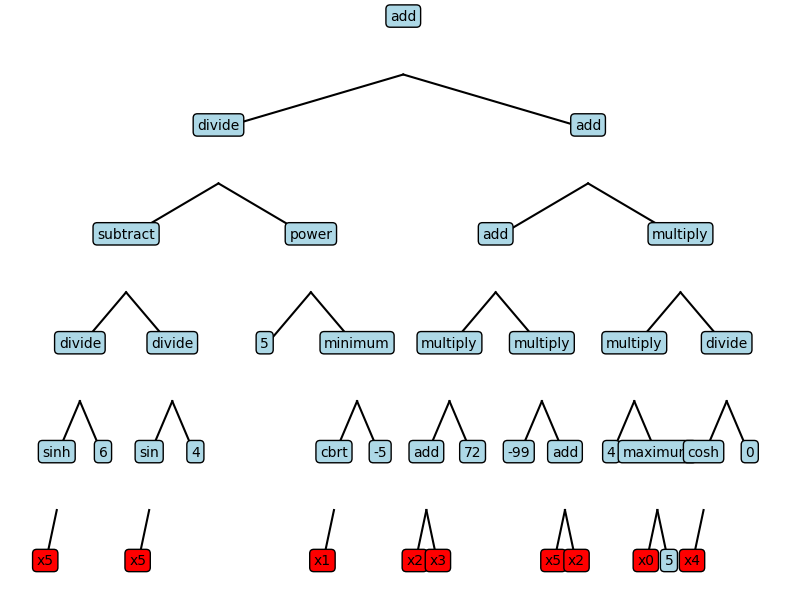

In [124]:
tree_clone = best_tree.copy_tree()
print(best_tree.to_np_formula())
Tree.collapse_branch(tree_clone.root,0,force_collapse=True)
tree_clone.compute_fitness()           
if(tree_clone.fitness is not None or tree_clone.fitness is not np.inf and tree_clone.fitness is not np.nan):
                    best_tree = tree_clone


print(f"Collapsed formula: {best_tree.to_np_formula(use_std_operators=True)}\n") #use_std_operators=True to use standard operators (+,-,*,/)
print("Tree drawing (after collapsing):")
best_tree.add_drawing()
